In [1]:
import os 
import pandas as pd  

3 401
5 381
0 500
0 500


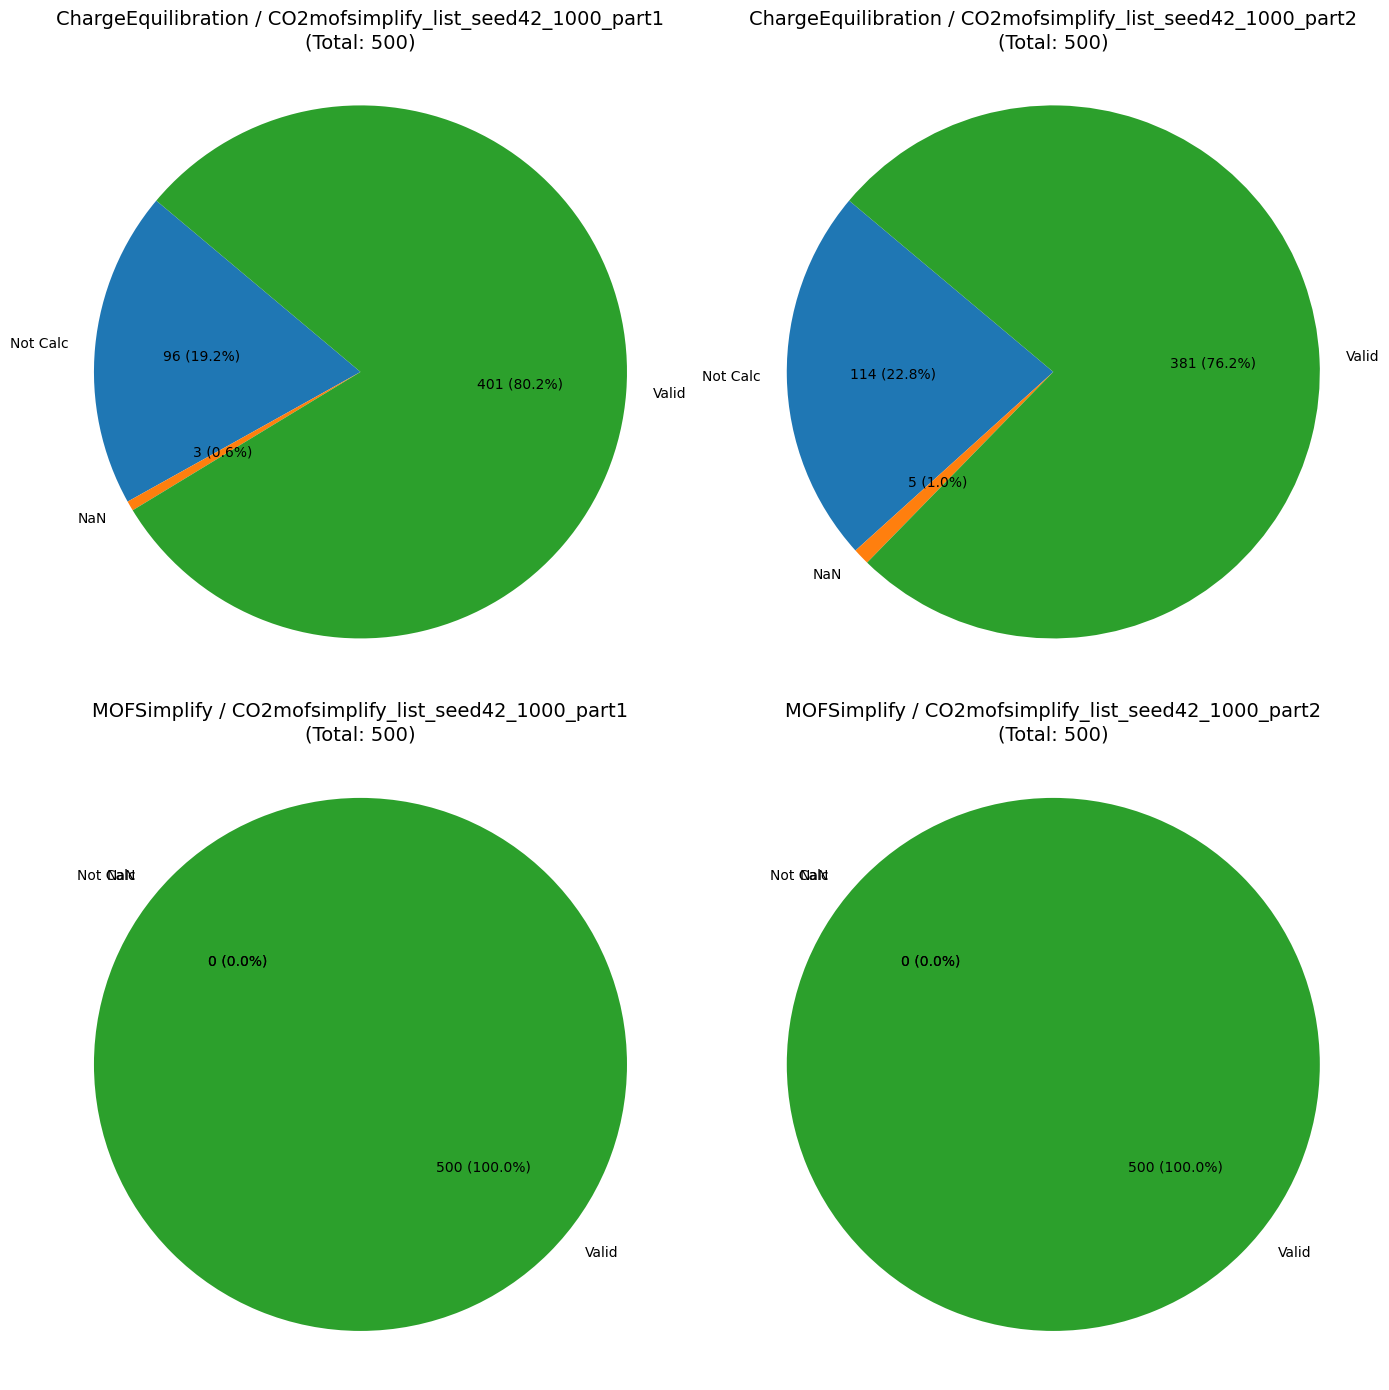

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# === 초기 설정 ===
first_entry = ["ChargeEquilibration", "MOFSimplify"]
second_entry = ["CO2mofsimplify_list_seed42_1000_part1", "CO2mofsimplify_list_seed42_1000_part2"]
dfname = "07result.csv"

# === 딕셔너리 초기화 ===
mof_charges_dict = defaultdict(dict)  # [first][second][name] -> {elements, charges}
nan_status_dict = defaultdict(lambda: defaultdict(lambda: {"nan": [], "not_nan": []}))

calculated_mofs_all = defaultdict(lambda: defaultdict(list))  # [first][second] -> list of names

# === 메인 타겟 MOF 목록 (part1 기준) ===
with open("ChargeEquilibration/CO2mofsimplify_list_seed42_1000_part1/mofsimplify_list_seed42_1000_part1.txt", 'r') as f:
    TARGET_MOFS_TOTAL = f.read().strip().split('\n')
    total_mof_count = len(TARGET_MOFS_TOTAL)

# === 데이터 수집 ===
for first in first_entry:
    for second in second_entry:
        df_path = os.path.join(first, second)
        df_full_path = os.path.join(df_path, dfname)

        if not os.path.exists(df_full_path):
            print(f"[경고] 파일 없음: {df_full_path}")
            continue

        try:
            DF = pd.read_csv(df_full_path)
        except Exception as e:
            print(f"[에러] CSV 읽기 실패: {df_full_path} - {e}")
            continue

        # 계산된 mof 목록
        calculated_mofs_all[first][second] = DF["name"].to_list()

        # 디렉토리 목록 탐색
        dirs = [d for d in os.listdir(df_path) if os.path.isdir(os.path.join(df_path, d))]
        mof_charges_dict[first][second] = {}

        for name in DF["name"].to_list():
            matched_dirs = [d for d in dirs if name in d]
            if not matched_dirs:
                continue

            d = matched_dirs[0]
            d2 = os.path.join(df_path, d, "Movies", "System_0")

            try:
                cif_file = [x for x in os.listdir(d2) if "final" in x and "P1.cif" in x][0]
                calcedcifpath = os.path.join(d2, cif_file)
                # 디버그용 출력
                # print(len(os.path.abspath(calcedcifpath)))
            except (FileNotFoundError, IndexError):
                continue

            # 원자명, 전하 리스트
            elements, charges = [], []
            with open(calcedcifpath, 'r') as f:
                lines = f.readlines()
                atom_data_started = False
                for line in lines:
                    if "_atom_site_charge" in line:
                        atom_data_started = True
                        continue
                    if atom_data_started:
                        parts = line.split()
                        if len(parts) >= 6:
                            element = parts[1]
                            try:
                                charge = float(parts[5])
                            except ValueError:
                                charge = np.nan
                            elements.append(element)
                            charges.append(charge)

            # NaN 여부 저장
            if all(np.isnan(charge) for charge in charges):
                nan_status_dict[first][second]["nan"].append(name)
            else:
                nan_status_dict[first][second]["not_nan"].append(name)

            mof_charges_dict[first][second][name] = {
                "elements": elements,
                "charges": charges
            }

# === 전체(전 조합) 계산된 MOF 집합 ===
calculated_mofs_set = set()
for first in calculated_mofs_all:
    for second in calculated_mofs_all[first]:
        calculated_mofs_set.update(calculated_mofs_all[first][second])

###################################################################
#       (2) 각 (first, second) 조합별 파이 차트 서브플롯         #
###################################################################
# 먼저 서브플롯을 생성: rows = len(first_entry), cols = len(second_entry)
rows = len(first_entry)
cols = len(second_entry)

fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))
# axes가 2차원 리스트/배열이 됨 (axes[i,j])

# 혹은 first,second 수가 2씩이니 2x2
# enumerate()를 사용하여 인덱스 i, j를 추적
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{count} ({pct:.1f}%)'
    return my_autopct

for i, fkey in enumerate(first_entry):
    for j, skey in enumerate(second_entry):
        ax = axes[i, j] if rows > 1 or cols > 1 else axes  # 서브플롯 참조

        # 이 조합에서 계산된 MOF들
        calculated_set = set(calculated_mofs_all[fkey][skey])  # list -> set
        # 조합별로 실제 'not_calculated' => (part1 txt 전체) - (이 조합에서 계산된)
        # === 메인 타겟 MOF 목록 (part1 기준) ===
        with open(f"{fkey}/{skey}/04cif_list.txt", 'r') as f:
            TARGET_MOFS_TOTAL = f.read().strip().split('\n')
        not_calculated_local = list(set(TARGET_MOFS_TOTAL) - calculated_set)

        # nan/not_nan
        local_nan_count = len(nan_status_dict[fkey][skey]["nan"])
        local_not_nan_count = len(nan_status_dict[fkey][skey]["not_nan"])
        print( local_nan_count, 
        local_not_nan_count)
        sizes_local = [len(not_calculated_local), local_nan_count, local_not_nan_count]
        labels = ['Not Calc', 'NaN', 'Valid']

        ax.pie(
            sizes_local,
            labels=labels,
            autopct=make_autopct(sizes_local),
            startangle=140
        )
        ax.axis('equal')  # 파이차트 원형 유지
        ax.set_title(f"{fkey} / {skey}\n(Total: {total_mof_count})", fontsize=14)

plt.tight_layout()
plt.show()


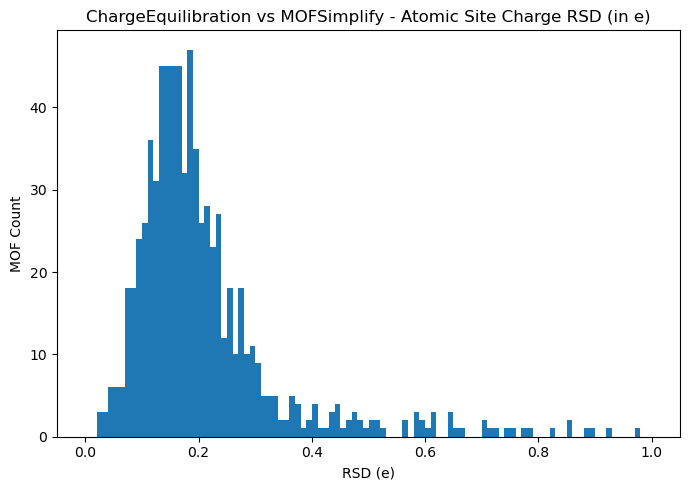

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 이 예시에서는 이미 mof_charges_dict가 존재한다고 가정
mof_charge_dict = mof_charges_dict

# (1) second_key 합쳐서 first_key별 단일 딕셔너리로
merged_dict = defaultdict(dict)
for fkey in mof_charge_dict:
    for skey in mof_charge_dict[fkey]:
        for mof_name, data in mof_charge_dict[fkey][skey].items():
            if mof_name not in merged_dict[fkey]:
                merged_dict[fkey][mof_name] = {
                    "elements": data["elements"],
                    "charges": data["charges"]
                }
            # 중복이면 원하는 방식으로 병합(여기선 무시)
            
# (2) ChargeEquilibration vs MOFSimplify 비교
CE_dict = merged_dict.get("ChargeEquilibration", {})
MS_dict = merged_dict.get("MOFSimplify", {})

common_mofs = set(CE_dict.keys()).intersection(set(MS_dict.keys()))
rsd_values_e = []  # 여기에 e 단위 표준편차를 저장

for mof in common_mofs:
    CE_charges = CE_dict[mof]["charges"]
    MS_charges = MS_dict[mof]["charges"]
    
    # 사이트 수가 다르면 스킵
    if len(CE_charges) != len(MS_charges):
        continue
    
    # 전하 차이 계산
    diffs = []
    for ce, ms in zip(CE_charges, MS_charges):
        if np.isnan(ce) or np.isnan(ms):
            # NaN이면 스킵 (또는 0으로 처리 등)
            continue
        diffs.append(ce - ms)
    
    if len(diffs) == 0:
        continue
    
    # "RSD"라는 이름이지만 실제론 stdev(diff)만 계산(단위: e)
    stdev_e = np.std(diffs)
    rsd_values_e.append(stdev_e)

# (3) 히스토그램 시각화
plt.figure(figsize=(7, 5))
plt.hist(rsd_values_e, bins=100, range=(0, 1))

# plt.xlim(0,1)
plt.xlabel("RSD (e)")   # 실제론 '표준편차(e)'와 비슷한 의미
plt.ylabel("MOF Count")
plt.title("ChargeEquilibration vs MOFSimplify - Atomic Site Charge RSD (in e)")
plt.tight_layout()
plt.show()


출처 : https://www.nature.com/articles/s41524-024-01413-4
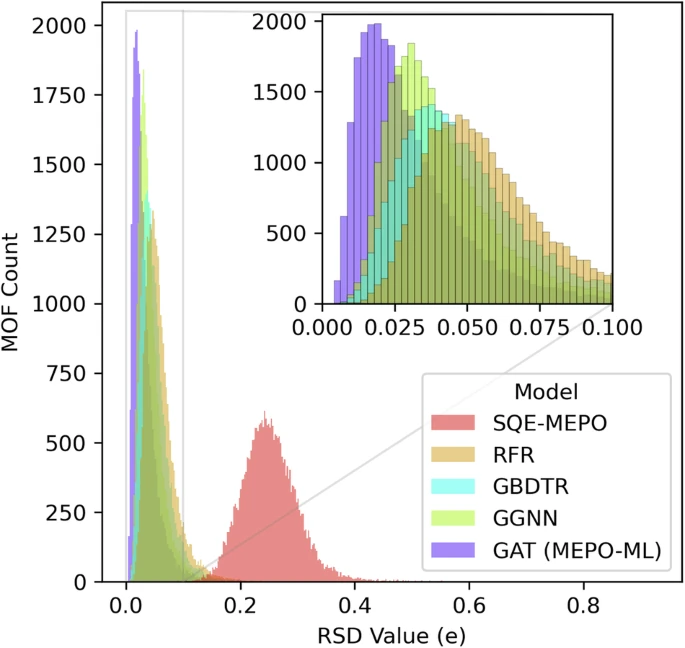
SQE MEPO의 charge equilibrium의 RSD결과와 비슷 
https://pubs.acs.org/doi/10.1021/acs.jpcc.6b10804

## 추가적인 분석

Charge를 Discrete하게 할당한다?

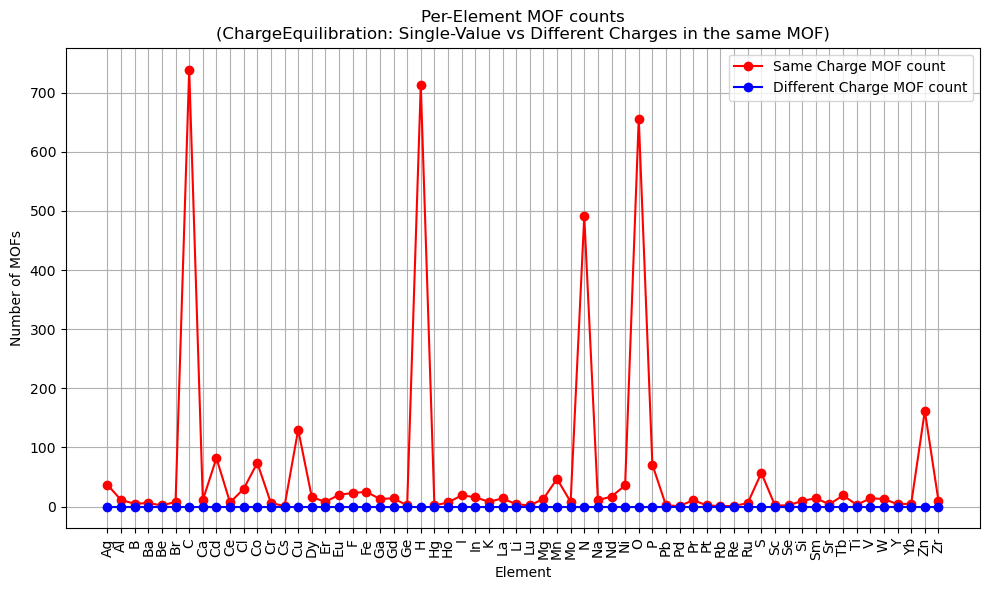

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 이미 mof_charges_dict 구조가 있다고 가정
# 예: mof_charges_dict[first_key][second_key][mof_name] = {
#      "elements": [...],
#      "charges":  [...]
# }

# (1) second_key 합쳐서 first_key별 단일 딕셔너리 생성
merged_dict = defaultdict(dict)
for fkey in mof_charges_dict:
    for skey in mof_charges_dict[fkey]:
        for mof_name, data in mof_charges_dict[fkey][skey].items():
            if mof_name not in merged_dict[fkey]:
                merged_dict[fkey][mof_name] = {
                    "elements": data["elements"],
                    "charges": data["charges"]
                }
            else:
                # 이미 있으면 무시 or 병합 로직 필요시 추가
                pass

# (2) ChargeEquilibration 딕셔너리만 사용
CE_dict = merged_dict.get("ChargeEquilibration", {})
if not CE_dict:
    print("No ChargeEquilibration data found.")
    raise SystemExit

# (3) 원소별로 'same' vs 'diff' MOF 수 카운트
#     element_summary[element] = {"same": 0, "diff": 0}
element_summary = defaultdict(lambda: {"same": 0, "diff": 0})

for mof_name, data in CE_dict.items():
    elements = data["elements"]
    charges  = data["charges"]
    if len(elements) != len(charges):
        continue  # 데이터 이상 → 스킵

    # 3-1) 원소별로 charges를 모아 그룹핑
    # 예: grouped_charges["C"] = [0.1, 0.1, 0.1], grouped_charges["O"] = [ -0.2, -0.21, ... ]
    grouped_charges = defaultdict(list)
    for elem, chg in zip(elements, charges):
        if not np.isnan(chg):
            grouped_charges[elem].append(chg)

    # 3-2) 각 원소에 대해 "모든 사이트가 같은 값인지" 판별
    for elem, chg_list in grouped_charges.items():
        if len(chg_list) <= 1:
            # 사이트가 1개뿐이면 자동으로 "same"
            element_summary[elem]["same"] += 1
        else:
            # 여러 사이트가 모두 같은 값인지 확인
            # (편의상 소수점 오차 고려 없이 직접 비교. 필요하면 round() 등 처리)
            first_val = chg_list[0]
            all_same = all(np.isclose(x, first_val, atol=1e-8) for x in chg_list)
            if all_same:
                element_summary[elem]["same"] += 1
            else:
                element_summary[elem]["diff"] += 1

# (4) 그래프 그리기
elements = sorted(element_summary.keys())
same_counts = [element_summary[e]["same"] for e in elements]
diff_counts = [element_summary[e]["diff"] for e in elements]

# x축이 문자열이므로, 인덱스를 만들어 사용
x_indices = np.arange(len(elements))

plt.figure(figsize=(10, 6))

# 빨간 실선 (일괄할당 MOF 수)
plt.plot(x_indices, same_counts, 'r-', marker='o', label="Same Charge MOF count")
# 파란 실선 (다르게 할당한 MOF 수)
plt.plot(x_indices, diff_counts, 'b-', marker='o', label="Different Charge MOF count")

plt.xticks(x_indices, elements, rotation=90)
plt.xlabel("Element")
plt.ylabel("Number of MOFs")
plt.title("Per-Element MOF counts\n(ChargeEquilibration: Single-Value vs Different Charges in the same MOF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Scatter Plot

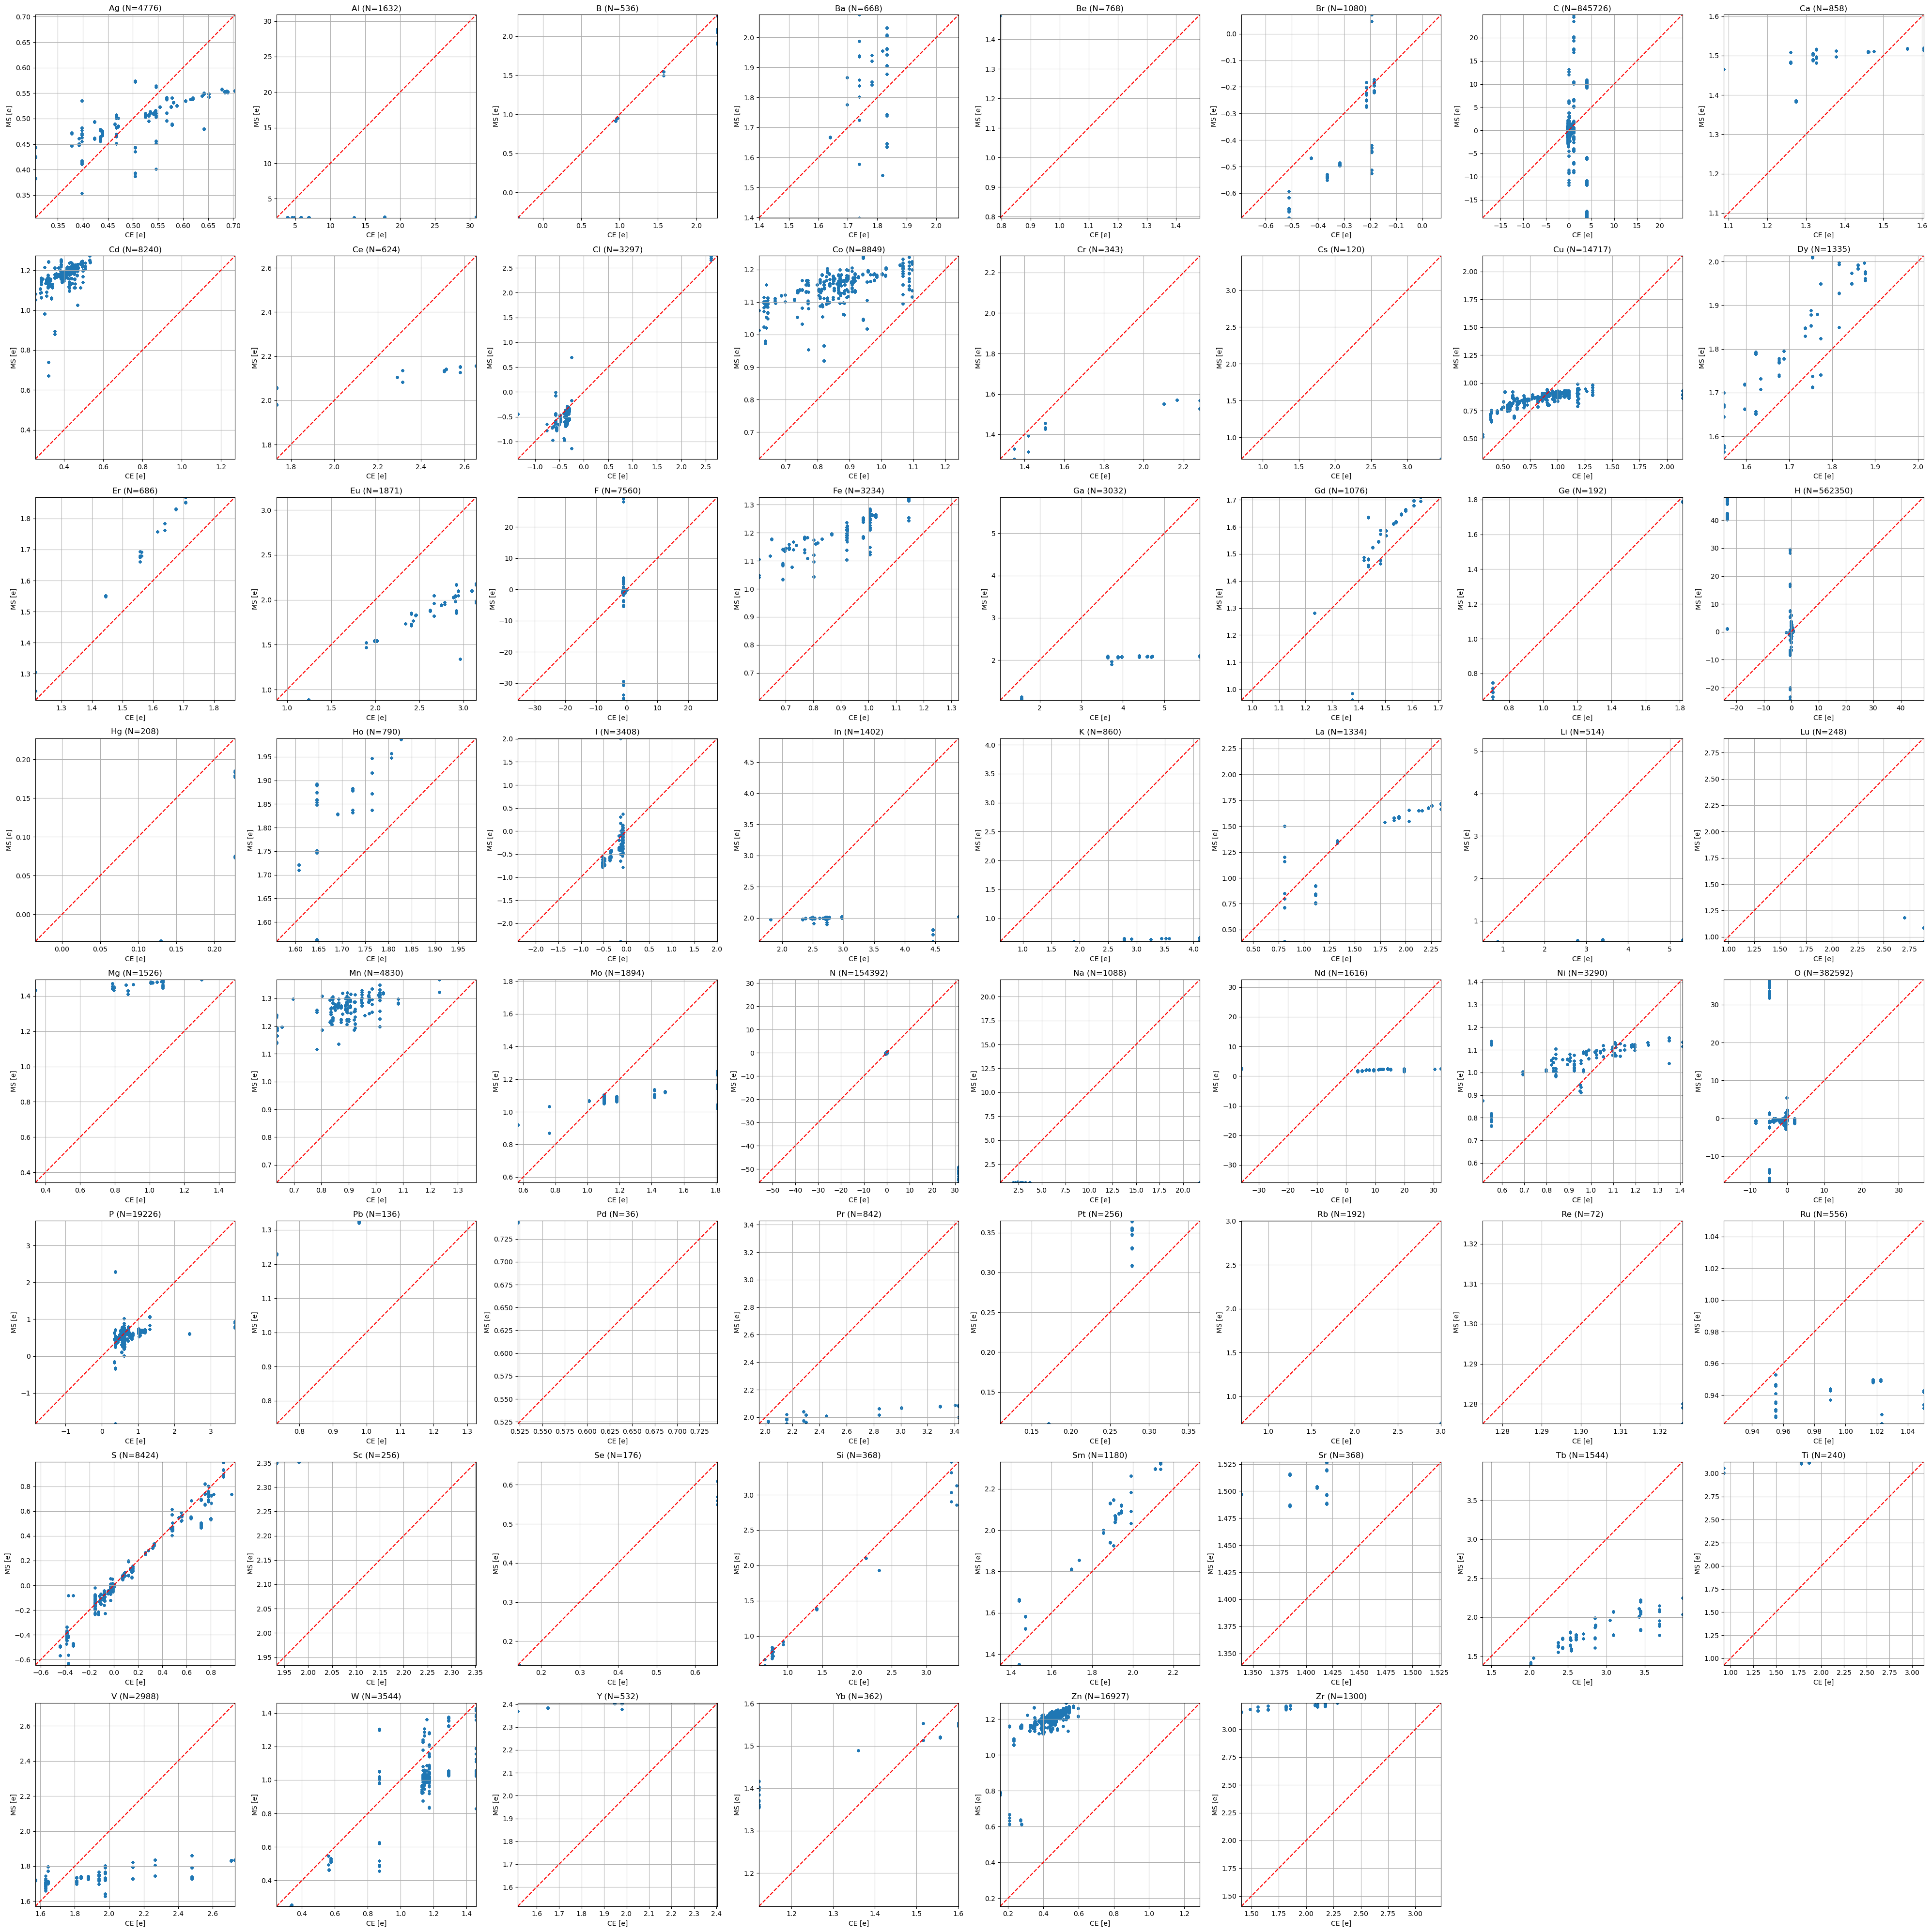

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 이미 mof_charges_dict 구조가 존재한다고 가정
# mof_charges_dict[first_key][second_key][mof_name] = {
#   "elements": [...],
#   "charges":  [...]
# }

mof_charge_dict = mof_charges_dict

# 1) second_key를 합쳐서 first_key별 단일 딕셔너리로
merged_dict = defaultdict(dict)
for fkey in mof_charges_dict:
    for skey in mof_charges_dict[fkey]:
        for mof_name, data in mof_charges_dict[fkey][skey].items():
            if mof_name not in merged_dict[fkey]:
                merged_dict[fkey][mof_name] = {
                    "elements": data["elements"],
                    "charges": data["charges"]
                }
            else:
                pass  # 이미 있으면 무시 or 병합

# 2) ChargeEquilibration vs MOFSimplify 공통 MOF 찾기
CE_dict = merged_dict.get("ChargeEquilibration", {})
MS_dict = merged_dict.get("MOFSimplify", {})

common_mofs = set(CE_dict.keys()).intersection(set(MS_dict.keys()))

# 3) 원소별 (CE, MS) 데이터 구조
element_dict = defaultdict(lambda: {"CE": [], "MS": []})

for mof in common_mofs:
    ce_data = CE_dict[mof]
    ms_data = MS_dict[mof]

    CE_charges = ce_data["charges"]
    MS_charges = ms_data["charges"]
    elements   = ce_data["elements"]  # 두 dict의 elements가 같다고 가정

    # 사이트 개수 일치 확인
    if len(CE_charges) != len(MS_charges) or len(elements) != len(CE_charges):
        continue

    for ce, ms, elem in zip(CE_charges, MS_charges, elements):
        if np.isnan(ce) or np.isnan(ms):
            continue
        element_dict[elem]["CE"].append(ce)
        element_dict[elem]["MS"].append(ms)

# 4) 원소 목록과 서브플롯 배열 결정
unique_elements = sorted(element_dict.keys())  # 가독성을 위해 정렬
n_elems = len(unique_elements)

if n_elems == 0:
    print("No element data to plot.")
else:
    # 정사각형에 가깝게 플롯하려고 sqrt(n_elems)로 행·열 지정
    grid_size = math.ceil(n_elems**0.5)

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(5*grid_size, 5*grid_size))
    # axes가 2차원 배열 형태로 [row][col] 인덱싱 가능
    # n_elems가 1인 경우에도 호환되도록 처리

    for idx, elem in enumerate(unique_elements):
        row = idx // grid_size
        col = idx % grid_size
        
        # subplot 참조
        if grid_size == 1:
            ax = axes  # subplot이 1개뿐이면 axes 자체
        else:
            ax = axes[row, col]

        CE_list = element_dict[elem]["CE"]
        MS_list = element_dict[elem]["MS"]

        if len(CE_list) == 0:
            # 데이터가 없으면 subplot 비활성화
            ax.set_visible(False)
            continue

        X = np.array(CE_list)
        Y = np.array(MS_list)

        # 공통 범위
        lower = min(X.min(), Y.min())
        upper = max(X.max(), Y.max())

        ax.scatter(X, Y, alpha=0.5, s=10)
        # y=x 라인
        ax.plot([lower, upper], [lower, upper], 'r--')

        ax.set_xlim(lower, upper)
        ax.set_ylim(lower, upper)

        ax.set_title(f"{elem} (N={len(X)})")
        ax.set_xlabel("CE [e]")
        ax.set_ylabel("MS [e]")
        ax.grid(True)

    # 남는 subplot 비활성화
    total_plots = grid_size * grid_size
    for leftover in range(n_elems, total_plots):
        row = leftover // grid_size
        col = leftover % grid_size
        if grid_size == 1:
            # 이미 위에서 처리, 여기서는 필요 없음
            pass
        else:
            axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()
